In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            torch.nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [3]:
# FashionMNIST 데이터는 28x28 크기의 흑백 이미지 데이터 입니다. 
# 이 입력에 대해 Flatten 계층에서 각 28x28의 2D 이미지를 784 픽셀 값을 갖는 연속된 배열로 변환합니다.
# 최종적으로 10개의 확률적 출력을 만들어 냅니다.

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

100%|██████████| 26421880/26421880 [00:05<00:00, 4597619.86it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 123579.73it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2209860.27it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2568368.86it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [7]:
# torchvision 의 datasets에서 FashionMNIST 데이터를 가져와서 torchvision 의 transforms.
# ToTensor() 로 텐서로 변환 합니다. transform 으로 ToTensor() 함수를 사용하는 것은 PIL 이미지 
# 또는 numpy.ndarray를 pytorch의 텐서로 변형시켜 줍니다. 그다음 batch_size=64 인 DataLoader 를 만들어 줍니다.

In [8]:
model = NeuralNetwork()
model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [9]:
#학습에 필요한 하이퍼 파라메터를 지정합니다.
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [10]:
# 손실함수와 옵티마이저를 정의 합니다.
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# 학습 loop 를 정의 합니다. 학습 단계(loop)에서 최적화는 세단계로 이뤄집니다:
# optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정합니다. 
# 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정합니다.
# loss.backward()를 호출하여 예측 손실(prediction loss)을 역전파합니다. 
# PyTorch는 각 매개변수에 대한 손실의 변화도를 저장합니다.
# 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정합니다.

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        X, y = X.to(device), y.to(device)  # 데이터를 디바이스로 이동
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # 데이터를 디바이스로 이동
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
# epoch 수만큼 train loop 를 수행하여 반복 학습 합니다.
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.481265  [    0/60000]
loss: 0.564891  [ 6400/60000]
loss: 0.425317  [12800/60000]
loss: 0.514748  [19200/60000]
loss: 0.439361  [25600/60000]
loss: 0.414125  [32000/60000]
loss: 0.316896  [38400/60000]
loss: 0.465594  [44800/60000]
loss: 0.410348  [51200/60000]
loss: 0.407755  [57600/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.410864 

Epoch 2
-------------------------------
loss: 0.338093  [    0/60000]
loss: 0.339053  [ 6400/60000]
loss: 0.273981  [12800/60000]
loss: 0.348115  [19200/60000]
loss: 0.342100  [25600/60000]
loss: 0.313984  [32000/60000]
loss: 0.269828  [38400/60000]
loss: 0.357739  [44800/60000]
loss: 0.324370  [51200/60000]
loss: 0.347413  [57600/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.382147 

Epoch 3
-------------------------------
loss: 0.271380  [    0/60000]
loss: 0.299321  [ 6400/60000]
loss: 0.254494  [12800/60000]
loss: 0.252058  [19200/60000]
loss: 0.308166  [25600/60000]
loss: 0.274323  [32000/600

value : tensor([5.2508], grad_fn=<MaxBackward0>), argmax : tensor([7]) 
 tensor([[-7.0137, -6.2008, -7.5730, -6.2311, -7.7941, -2.4103, -6.9803,  5.2508,
         -4.9450, -3.1786]], grad_fn=<AddmmBackward0>)
value : tensor([3.3507], grad_fn=<MaxBackward0>), argmax : tensor([6]) 
 tensor([[ 1.8396, -5.7352,  1.0234, -1.1033, -1.5432, -7.0462,  3.3507, -6.7661,
         -3.8186, -7.3224]], grad_fn=<AddmmBackward0>)
value : tensor([4.4679], grad_fn=<MaxBackward0>), argmax : tensor([4]) 
 tensor([[-5.3235, -3.7339, -2.8684,  3.7714,  4.4679, -7.3473, -0.5838, -7.3153,
         -6.1357, -8.9821]], grad_fn=<AddmmBackward0>)


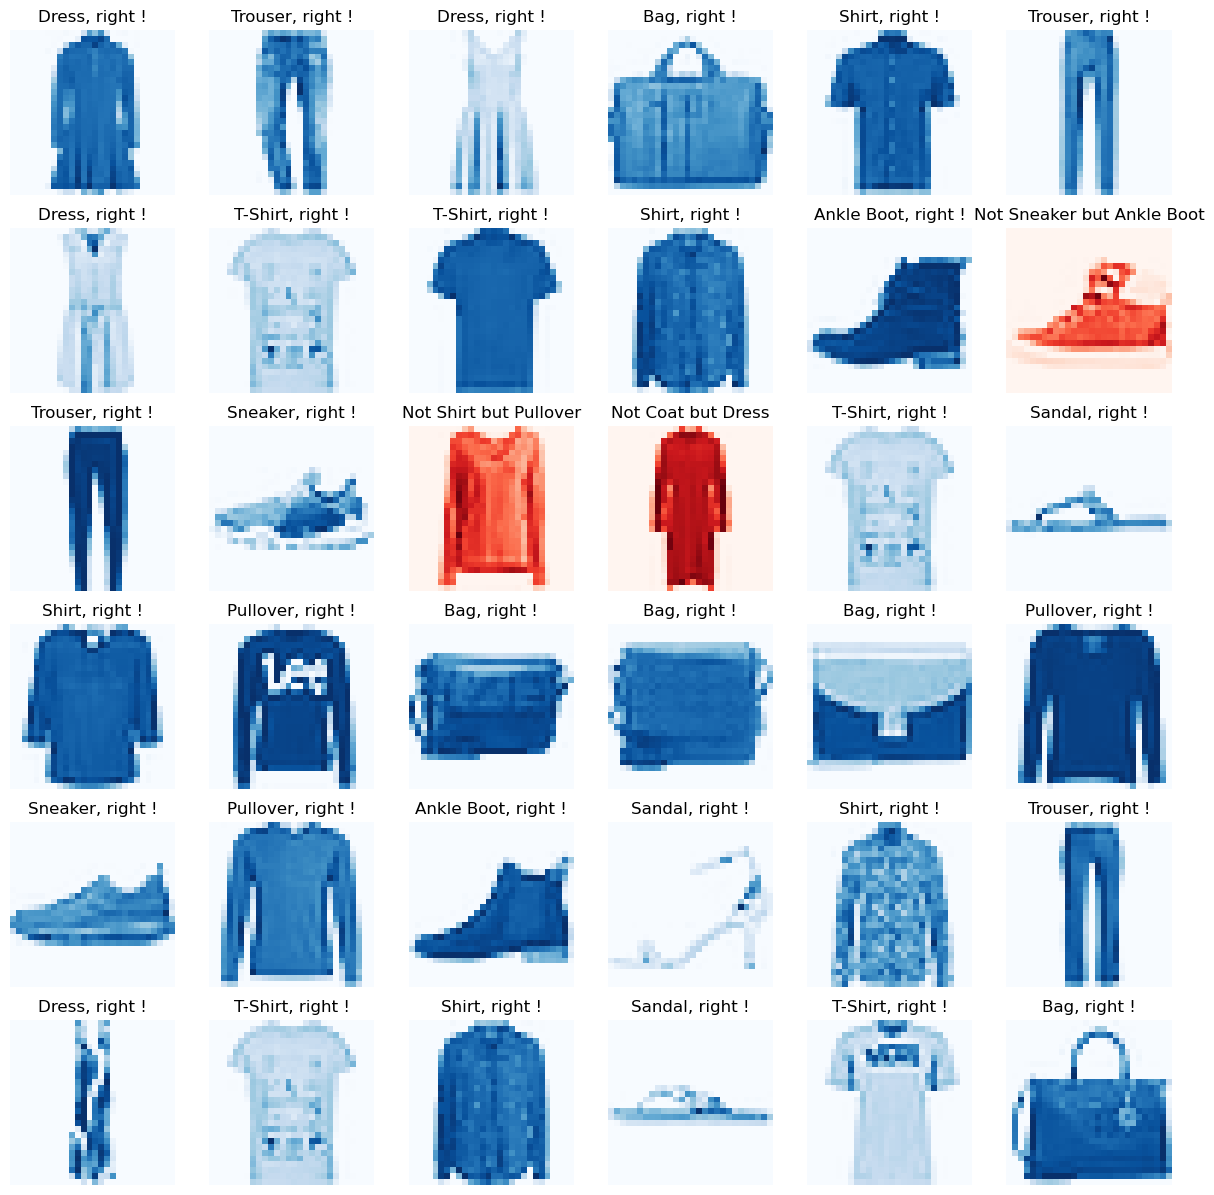

In [14]:
# 6x6=36 개의 이미지를 테스트 해봅니다.
import matplotlib.pyplot as plt
import numpy as np

label_tags = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

columns = 6
rows = 6

fig = plt.figure(figsize=(15,15))

# batch size와 다른사이즈(ex:1개)를 테스트 할경우에는 eval 호출 필요
model.eval()

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataloader))
    input_img = test_data[data_idx][0].to(device)
    # print(input_img.shape)

    output = model(input_img)
    value, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    label = label_tags[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !')
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
        print(f"value : {value}, argmax : {argmax} \n {output}")

    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()

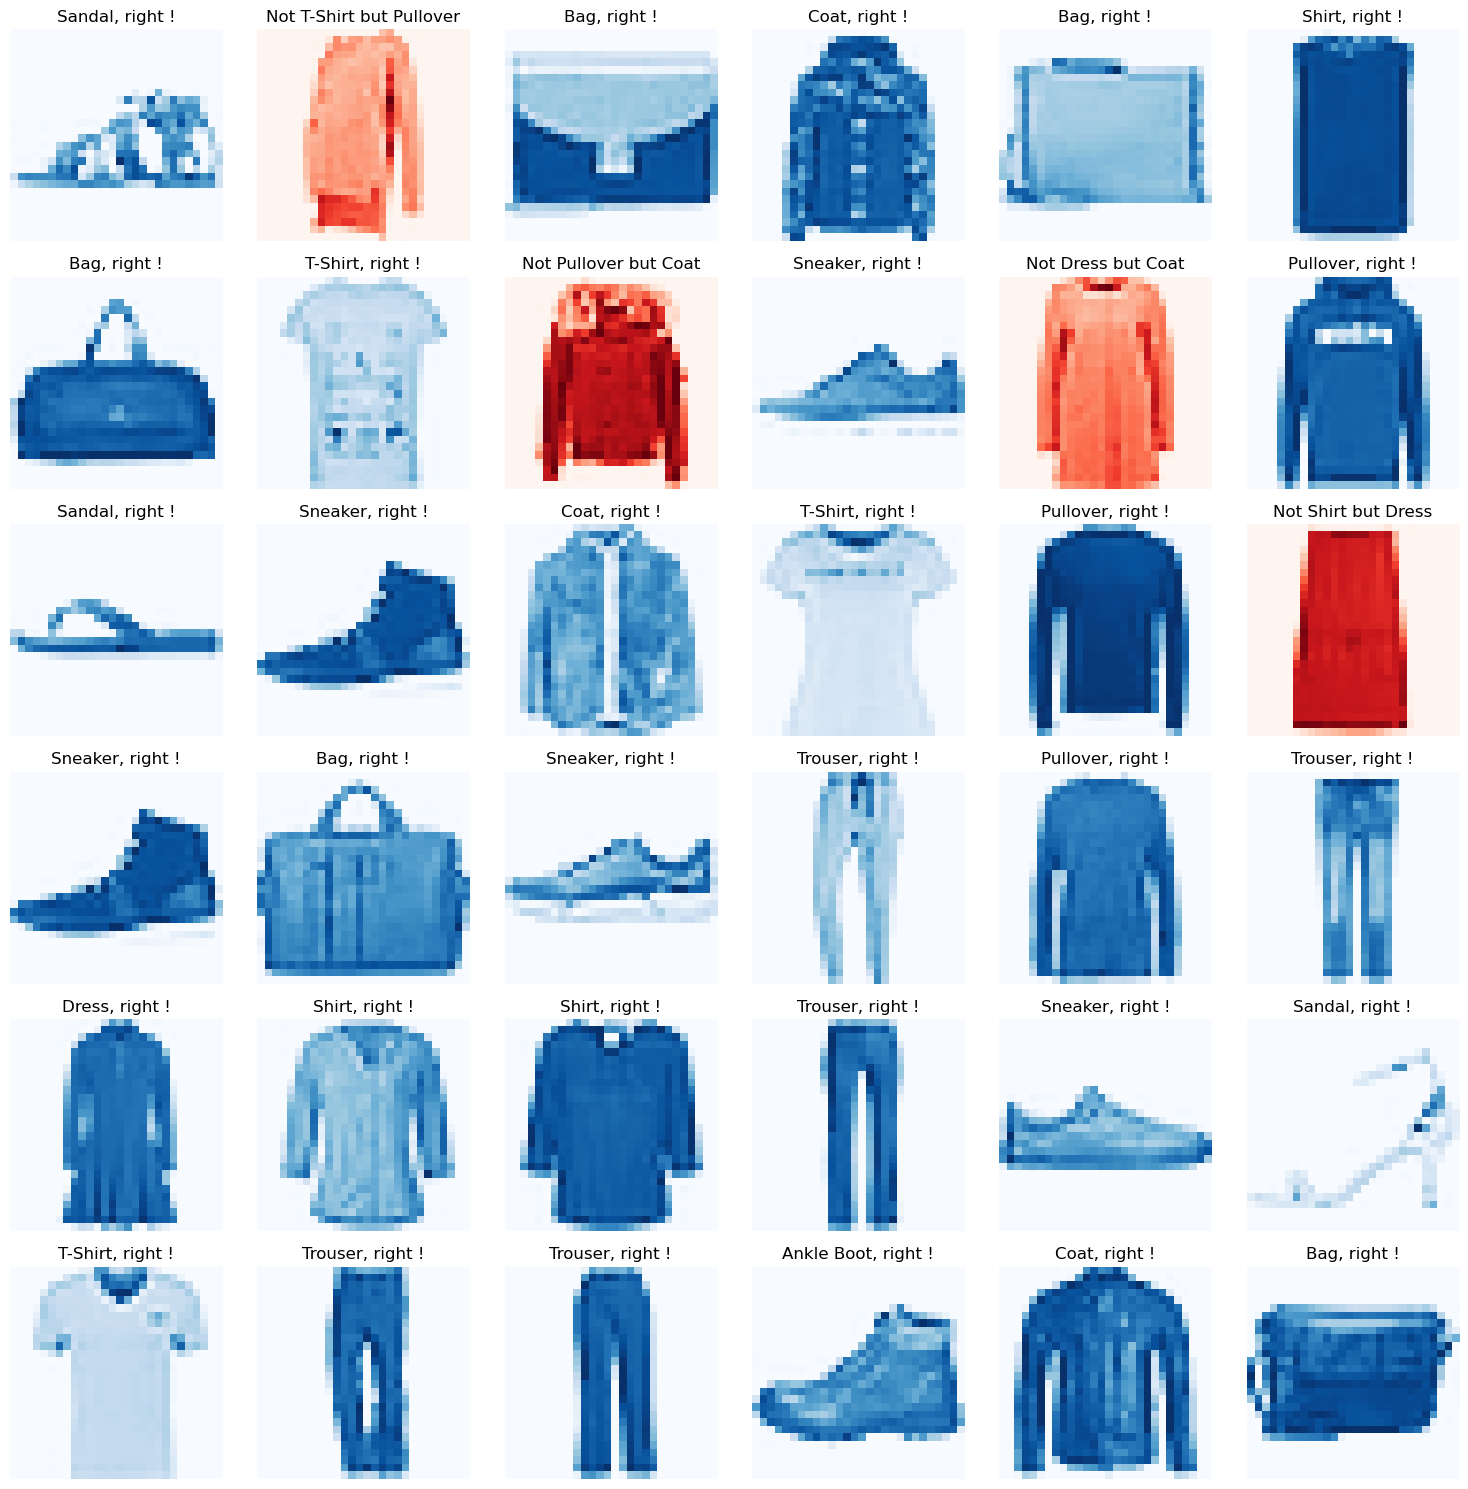

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 레이블에 대응하는 태그
label_tags = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

columns = 6
rows = 6

fig = plt.figure(figsize=(15, 15))

# batch size와 다른사이즈(ex:1개)를 테스트 할경우에는 eval 호출 필요
model.eval()  # 모델을 평가 모드로 변경

for i in range(1, columns * rows + 1):
    data_idx = np.random.randint(len(test_dataloader))
    input_img, label = test_data[data_idx][0].to(device), test_data[data_idx][1]

    # 이미지 예측
    with torch.no_grad():
        output = model(input_img)
        _, prediction = torch.max(output, 1)
        pred_class = label_tags[prediction.item()]
        true_class = label_tags[label]

    # 제목과 색상 설정
    title = f'{pred_class}, right !' if pred_class == true_class else f'Not {pred_class} but {true_class}'
    cmap = 'Blues' if pred_class == true_class else 'Reds'

    fig.add_subplot(rows, columns, i)
    plot_img = input_img.squeeze().cpu().numpy()  # 텐서를 넘파이 배열로 변환하여 이미지 플로팅
    plt.imshow(plot_img, cmap=cmap)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
a = torch.randn(4, 4)
a

tensor([[-0.2215,  1.0862, -0.3129,  0.6388],
        [ 1.1463,  0.7514,  0.3154, -1.0929],
        [-0.2106,  0.3954, -0.3452,  1.1288],
        [-0.0447, -0.1397,  0.9411, -0.3841]])

In [17]:
torch.max(a, 1)

torch.return_types.max(
values=tensor([1.0862, 1.1463, 1.1288, 0.9411]),
indices=tensor([1, 0, 3, 2]))

In [18]:
torch.max(a)

tensor(1.1463)

In [19]:
torch.max(a, -1)

torch.return_types.max(
values=tensor([1.0862, 1.1463, 1.1288, 0.9411]),
indices=tensor([1, 0, 3, 2]))

In [20]:
test_data[data_idx][0].shape

torch.Size([1, 28, 28])

In [21]:
input_img.squeeze().shape

torch.Size([28, 28])

In [22]:
output = model(input_img)
print(output)

tensor([[-3.1291, -8.8837, -8.7354, -7.3925, -5.9489, -3.2923, -3.4907, -3.7161,
         10.3095, -5.7680]], grad_fn=<AddmmBackward0>)


In [23]:
torch.max(output, 1)

torch.return_types.max(
values=tensor([10.3095], grad_fn=<MaxBackward0>),
indices=tensor([8]))